In [1]:
import numpy as np

In [2]:
import cv2

In [3]:
import os

In [4]:
import matplotlib.pyplot as plt

In [5]:
IMG_NAME = 'un-nouveau-billet-de-10-euros-pour-lutter-contre-la-contrefacon-902093.jpg'
MIRE_NAME = 'mirebillet.jpg'
PROJECT_FOLDER = '/Users/walid/Downloads/'

In [6]:
def matchesSIFT(img, mire):
    img_gr = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mire_gr = cv2.cvtColor(mire, cv2.COLOR_BGR2GRAY)
    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img_gr,None)
    kp2, des2 = sift.detectAndCompute(mire_gr,None)
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    MIN_MATCH_COUNT = 10
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()

        h,w = img_gr.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)

        img2 = cv2.polylines(mire_gr,[np.int32(dst)],True,255,3, cv2.LINE_AA)

    else:
        print( "Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
        matchesMask = None
    draw_params = dict(# draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

    img3 = cv2.drawMatches(img_gr,kp1,img2,kp2,good,None,**draw_params)
    f = plt.figure(figsize=(13,13))
    plt.imshow(img3, 'gray'),plt.show()

In [7]:
IMG_PATH = os.path.join(PROJECT_FOLDER, IMG_NAME)
MIRE_PATH = os.path.join(PROJECT_FOLDER, MIRE_NAME)
img = cv2.imread(IMG_PATH)
mire = cv2.imread(MIRE_PATH)

In [8]:
plt.imshow(img)

In [9]:
plt.imshow(mire)

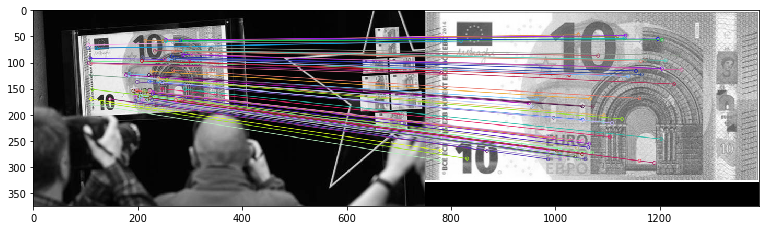

In [10]:
matchesSIFT(img, mire)

In [70]:
MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15

def alignImages(im1, im2):    
    # Convert images to grayscale
    im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)

    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]

    # Draw top matches
    imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
    cv2.imwrite("matches.jpg", imMatches)

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Use homography
    height, width, channels = im2.shape
    im1Reg = cv2.warpPerspective(im1, h, (width, height))

    return im1Reg, h

Reading reference image :  /Users/walid/Downloads/mirebillet.jpg
Reading image to align :  /Users/walid/Downloads/un-nouveau-billet-de-10-euros-pour-lutter-contre-la-contrefacon-902093.jpg
Aligning images ...
Saving aligned image :  aligned.jpg
Estimated homography : 
 [[ 2.01835800e+00 -8.82476319e-01 -5.51428187e+01]
 [ 2.19933314e-01  1.60472987e+00 -8.22852401e+01]
 [ 3.24928159e-04 -1.35565819e-03  1.00000000e+00]]


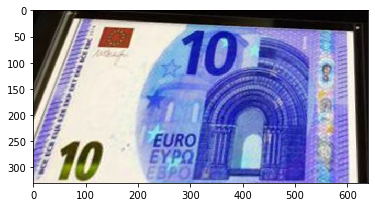

In [71]:
# Read reference image
refFilename = MIRE_PATH
print("Reading reference image : ", refFilename)
imReference = cv2.imread(refFilename, cv2.IMREAD_COLOR)

# Read image to be aligned
imFilename = IMG_PATH
print("Reading image to align : ", imFilename);  
im = cv2.imread(imFilename, cv2.IMREAD_COLOR)

print("Aligning images ...")
# Registered image will be resotred in imReg. 
# The estimated homography will be stored in h. 
imReg, h = alignImages(im, imReference)

# Write aligned image to disk. 
outFilename = "aligned.jpg"
print("Saving aligned image : ", outFilename); 
plt.imshow(imReg)

# Print estimated homography
print("Estimated homography : \n",  h)

In [69]:
dst

array([[[-222.86075 , -119.61276 ]],

       [[-280.2697  ,  712.08813 ]],

       [[1343.6599  ,  701.57056 ]],

       [[1377.0869  ,   14.865694]]], dtype=float32)

In [52]:
img_gr = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mire_gr = cv2.cvtColor(mire, cv2.COLOR_BGR2GRAY)

In [53]:
plt.imshow(img_gr, cmap='gray')

In [54]:
plt.imshow(mire_gr, cmap='gray')

In [39]:
#mire_gr = cv2.rotate(mire_gr, cv2.ROTATE_90_CLOCKWISE)

In [55]:
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

In [56]:
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img_gr,None)
kp2, des2 = sift.detectAndCompute(mire_gr,None)

In [57]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

In [58]:
flann = cv2.FlannBasedMatcher(index_params, search_params)

In [59]:
matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [60]:
MIN_MATCH_COUNT = 10

In [61]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    h,w = img_gr.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    img2 = cv2.polylines(mire_gr,[np.int32(dst)],True,255,3, cv2.LINE_AA)

else:
    print( "Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None

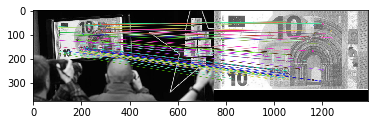

(<matplotlib.image.AxesImage at 0x12786c650>, None)

In [62]:
draw_params = dict(# draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(img_gr,kp1,img2,kp2,good,None,**draw_params)

plt.imshow(img3, 'gray'),plt.show()

In [14]:
img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

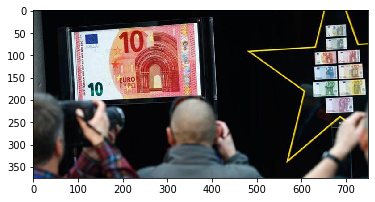

In [15]:
plt.imshow(img_rgb)

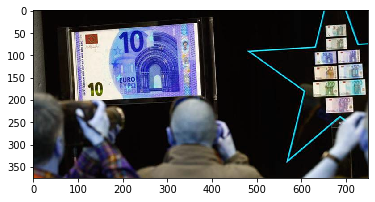

In [17]:
plt.imshow(img)

In [103]:
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
thresh = cv2.Canny(imgray, 50, 50)
im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

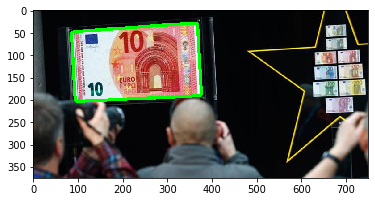

In [116]:
imgcop = img_rgb.copy()
# imgcop = cv2.drawContours(imgcop, contours, 2241, (0,255,0), 5)
imgcop = cv2.drawContours(imgcop, [cv2.convexHull(contours[2241])], 0, (0,255,0), 5)
plt.imshow(imgcop)

In [117]:
cv2.boundingRect(contours[2241])

(86, 29, 291, 175)

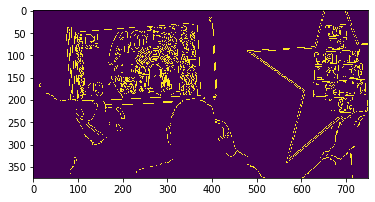

In [112]:
plt.imshow(cv2.Canny(imgray, 100, 200))

In [106]:
[
    t
    for t in sorted([(i, cv2.contourArea(cnt)) for i, cnt in enumerate(contours)], key=lambda t: t[-1])
    if t[-1] > 20
][::-1]

[(1656, 3037.0),
 (2241, 2467.0),
 (807, 2038.5),
 (808, 2035.5),
 (1170, 1978.5),
 (1171, 1976.5),
 (1105, 1850.5),
 (1106, 1848.5),
 (2120, 1753.0),
 (1446, 1708.0),
 (1448, 1684.5),
 (1376, 1486.0),
 (1378, 1468.5),
 (1745, 1343.5),
 (1747, 1323.5),
 (1616, 1319.5),
 (1617, 1316.5),
 (2136, 1173.0),
 (1933, 1162.0),
 (2198, 1161.5),
 (2200, 1145.5),
 (1940, 870.5),
 (1992, 590.0),
 (1993, 588.5),
 (1706, 540.0),
 (2411, 506.5),
 (2121, 506.5),
 (1081, 458.0),
 (2177, 451.0),
 (1082, 445.0),
 (1657, 443.5),
 (2179, 398.0),
 (1685, 341.0),
 (2150, 328.0),
 (1831, 322.5),
 (1808, 322.0),
 (2151, 321.0),
 (2412, 284.5),
 (1935, 260.0),
 (1722, 231.5),
 (1055, 231.5),
 (1056, 220.0),
 (2302, 210.5),
 (2344, 205.0),
 (1592, 204.0),
 (1677, 184.5),
 (1701, 180.5),
 (2274, 149.0),
 (2363, 147.0),
 (2034, 146.0),
 (2267, 131.0),
 (1730, 130.5),
 (835, 129.0),
 (2271, 126.0),
 (1879, 112.5),
 (2285, 108.0),
 (2384, 105.0),
 (2383, 105.0),
 (1234, 102.0),
 (2351, 89.0),
 (986, 89.0),
 (1237, 8

In [221]:
IMG_NAME = 'Immeuble-de-logements-Carteret_A-la-une-1080x756.jpg'
PROJECT_FOLDER = '/Users/walid/Downloads/'

In [222]:
original_image = cv2.imread(os.path.join(PROJECT_FOLDER, IMG_NAME))
img = cv2.cvtColor(original_image,cv2.COLOR_BGR2RGB)

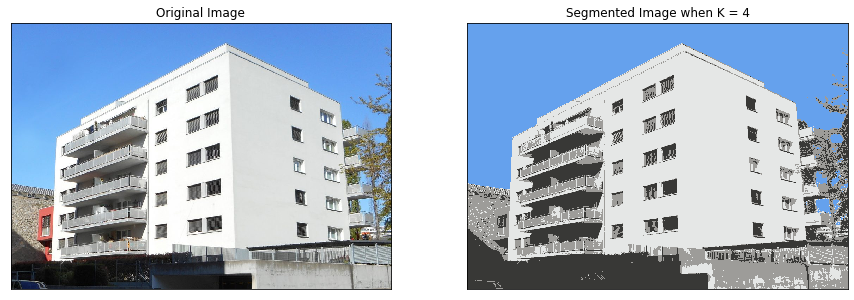

In [224]:
vectorized = img.reshape((-1,3))
vectorized = np.float32(vectorized)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 4
attempts=20
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((img.shape))
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

In [240]:
img0 = cv2.imread(os.path.join(PROJECT_FOLDER, IMG_NAME))

# converting to gray scale
gray = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)

# remove noise
img = cv2.GaussianBlur(gray,(3,3),0)

# convolute with proper kernels
laplacian = cv2.Laplacian(img,cv2.CV_64F)
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)  # x
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)  # y

plt.figure(figsize=(15, 15))
plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.show()

In [228]:
gray.dtype

dtype('uint8')

In [232]:
sobelx.max(), sobelx.min()

(10189.0, -9066.0)

In [241]:
tonorm = sobelx.copy()
normsobel = ((tonorm - tonorm.min()) / (tonorm.max() - tonorm.min()) * 255).astype(np.uint8)
plt.imshow(normsobel)

In [242]:
edges = cv2.Canny(normsobel,30,30)
plt.imshow(edges)

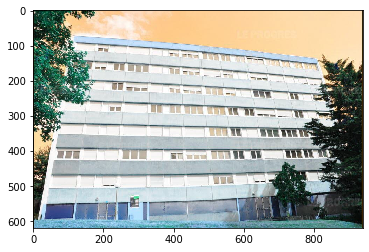

In [127]:
plt.imshow(img)

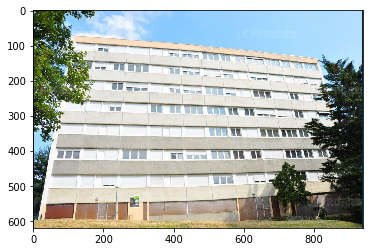

In [128]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

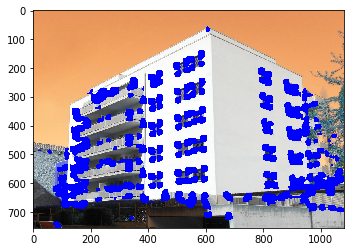

In [247]:
img = cv2.imread(os.path.join(PROJECT_FOLDER, IMG_NAME))
#img = cv2.cvtColor(original_image,cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,21,21,0.02)

#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)

# Threshold for an optimal value, it may vary depending on the image.
imgcop = img.copy()
imgcop[dst>0.01*dst.max()]=[0,0,255]
plt.imshow(imgcop)

In [248]:
im = img.copy()
imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 127, 255, 0)
im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


In [249]:
cnts = [(i,len(cnt), cnt, cv2.contourArea(cnt), cv2.arcLength(cnt, True))for i, cnt in enumerate(contours)]
cnts = [item for item in cnts if item[3] > 10]
cnts = sorted(cnts, key=lambda t: t[3])[::-1]

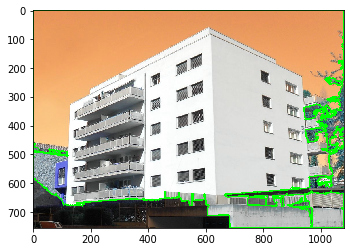

In [253]:
im = img.copy()
cv2.drawContours(im, [cnts[0][2]], -1, (0,255,0), 3)
plt.imshow(im)

In [254]:
im = img.copy()
gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

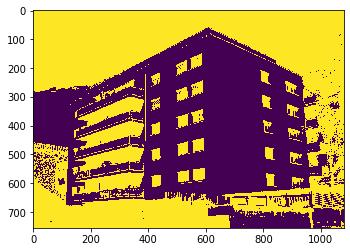

In [255]:
plt.imshow(thresh)

In [1]:
from libs.rectification import *

In [2]:
IMG_NAME = "2019-05-09 10.26.04.jpg"

In [4]:
import skimage
from skimage import io

In [9]:
import matplotlib.pyplot as plt

In [8]:
image = io.imread(f'data/samples/{IMG_NAME}')

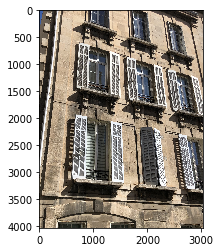

In [10]:
plt.imshow(image)

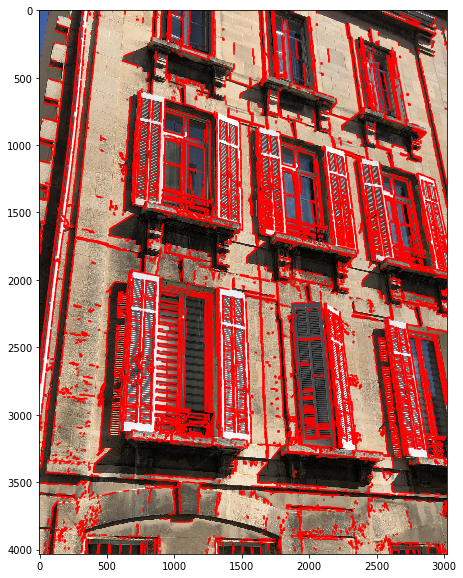

In [11]:
edgelets1 = compute_edgelets(image)
vis_edgelets(image, edgelets1)

/Users/walid/Documents/Projects/Pericolo/libs/rectification.py:111: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(np.abs(cosine_theta))
/Users/walid/Documents/Projects/Pericolo/libs/rectification.py:114: RuntimeWarning: invalid value encountered in less
  return (theta < theta_thresh) * strengths
/Users/walid/Documents/Projects/Pericolo/libs/rectification.py:278: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  est_model = np.linalg.lstsq(a, b)[0]


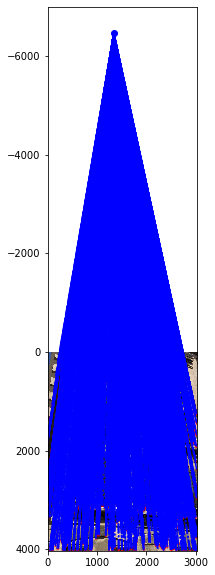

In [12]:
vp1 = ransac_vanishing_point(edgelets1, num_ransac_iter=2000, 
                             threshold_inlier=5)
vp1 = reestimate_model(vp1, edgelets1, threshold_reestimate=5)
vis_model(image, vp1) # Visualize the vanishing point model

In [18]:
vp1 = ransac_vanishing_point(edgelets1, num_ransac_iter=2000, 
                             threshold_inlier=5)
vp1 = reestimate_model(vp1, edgelets1, threshold_reestimate=5)
#vis_model(image, vp1bis) # Visualize the vanishing point model

In [19]:
edgelets2 = remove_inliers(vp1, edgelets1, 10)
vp2 = ransac_vanishing_point(edgelets2, num_ransac_iter=2000,
                             threshold_inlier=5)
vp2 = reestimate_model(vp2, edgelets2, threshold_reestimate=5)

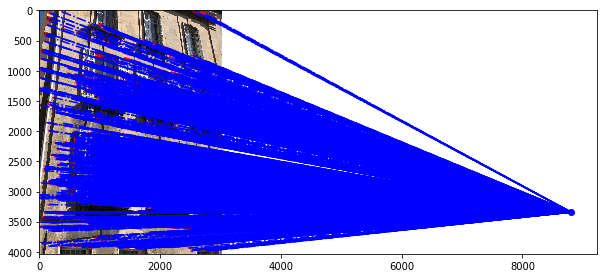

In [20]:
vis_model(image, vp2) # Visualize the vanishing point model

In [22]:
warped_img = compute_homography_and_warp(image, vp1, vp2, clip_factor=6)

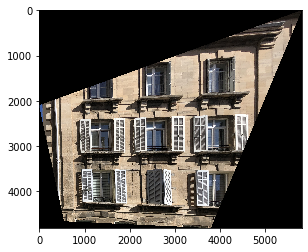

In [23]:
plt.imshow(warped_img)